In [1]:
import os, sys
import cv2
import gradio as gr
import numpy as np
from PIL import Image, ImageDraw

In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

In [3]:
from common.config import get_config_info
config = get_config_info(os.path.join('.', 'config', 'settings1.json'))

In [4]:
SAMPLE1 = config['sample1']
SAMPLE2 = config['sample2']

In [5]:
from common.image import get_font, random_color
font = get_font()

In [6]:
# function
weights_path = os.path.join('.', 'model', 'yolov3.weights')
config_path = os.path.join('.', 'model', 'yolov3.cfg')
names_path = os.path.join('.', 'model', 'coco_korean.names')

In [7]:
net = cv2.dnn.readNet(weights_path, config_path)

with open(names_path, 'r', encoding="UTF-8") as file:
    label_list = file.read().strip().split('\n')

print(net, label_list)

< cv2.dnn.Net 00000225AA794A90> ['사람', '자전거', '자동차', '오토바이', '비행기', '버스', '기차', '트럭', '보트', '신호등', '소화전', '정지 표지판', '주차 요금 기기', '벤치', '새', '고양이', '개', '말', '양', '소', '코끼리', '곰', '얼룩말', '기린', '배낭', '우산', '핸드백', '넥타이', '여행 가방', '프리즈비', '스키', '스노보드', '스포츠 공', '연', '야구 배트', '야구 글러브', '스케이트보드', '서핑보드', '테니스 라켓', '병', '와인잔', '컵', '포크', '칼', '숟가락', '그릇', '바나나', '사과', '샌드위치', '오렌지', '브로콜리', '당근', '핫도그', '피자', '도넛', '케이크', '의자', '소파', '화분', '침대', '식탁', '화장실', 'TV 모니터', '노트북', '마우스', '리모컨', '키보드', '휴대폰', '전자레인지', '오븐', '토스터', '싱크대', '냉장고', '책', '시계', '꽃병', '가위', '테디베어', '헤어 드라이어', '칫솔']


In [8]:
def detect_objects(image):
    drawn_image = Image.fromarray(image.copy())
    draw = ImageDraw.Draw(drawn_image)

    # 이미지의 height, width 를 뽑아낸다.
    height, width = image.shape[:2]
    # print(height, width)
    
    # blob 을 생성하고 전방향 전파 진행
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob=blob)
    layer_names_list = net.getLayerNames()
    output_layer_list = [layer_names_list[i - 1] for i in net.getUnconnectedOutLayers()]

    # yolo_82, yolo_94, yolo_102 총 3개의 레이어들이 예측을 진행. detection_list에는 총 3개의 예측이 있음.
    detection_list = net.forward(output_layer_list)

    bounding_box_list = list()
    confidence_list = list()
    class_index_list = list()

    for output in detection_list:
        # output : 각 레이어의 예측 정보
        for detection in output:
            # detection : 총 85개. x, y, w, h, confidence + 총 80개의 names 정보.
            score_list = detection[5:]
            class_index = np.argmax(score_list)
            confidence = score_list[class_index]
            if confidence > 0:
                print(class_index, label_list[class_index], confidence)
                bounding_box = detection[:4] * np.array([width, height, width, height])
                center_x, center_y, w, h = bounding_box.astype('int')
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                if x < 0:
                    x = 0
                if y < 0:
                    y = 0
                
                # print(x, y, w, h)

                bounding_box_list.append([x, y, w, h])
                confidence_list.append(confidence)
                class_index_list.append(class_index)

                # draw.rectangle((x, y, x + w, y + h), outline=(0, 255, 0), width=3)
                # draw.text((x + 5, y + 5), font=font, text='{} {:0.2f}%'.format(label_list[class_index], confidence * 100), fill=(255, 0, 0))

            # print(detection[:5])
            # print(detection[5:])
    
    # NMSBoxes 를 이용해서 중복을 제거한다.
    extracted_index_list = cv2.dnn.NMSBoxes(bounding_box_list, confidence_list, 0.5, 0.4)
    # print(class_index_list, extracted_index_list)

    for extracted_index in extracted_index_list:
        x, y, w, h = bounding_box_list[extracted_index]
        confidence = confidence_list[extracted_index]
        class_index = class_index_list[extracted_index]
        label = label_list[class_index]

        color = random_color()
        print(label, x, y, w, h, confidence)

        draw.rectangle((x, y, x + w, y + h), outline=color, width=3)
        draw.text((x + 5, y + 5), font=font, text='{} {:0.2f}%'.format(label_list[class_index], confidence * 100), fill=color)
    
    # print(image)
    return drawn_image

42 포크 0.824756
42 포크 0.5203353
42 포크 0.67377645
42 포크 0.64499557
42 포크 0.93784
42 포크 0.74638945
42 포크 0.8940296
42 포크 0.81225234
포크 96 185 526 307 0.93784


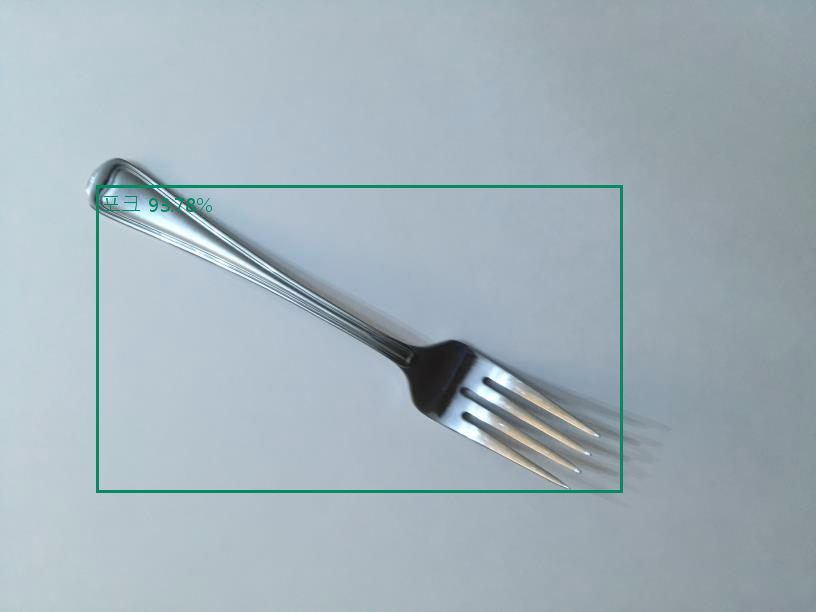

In [9]:
image = cv2.imread(os.path.join('.', 'data', SAMPLE1))
detect_objects(image)

In [10]:
box = np.array([1, 2, 3, 4]) * np.array([1, 2, 3, 4.123])
box = box.astype('int')
print(box)

[ 1  4  9 16]


In [11]:
with gr.Blocks() as demo1:

    def stream_webcam(image):
        drawn_image = detect_objects(image)
        return drawn_image
    
    webcam_input = gr.Image(label='실시간 화면', sources='webcam', width=480, height=270, mirror_webcam=False)
    output_image = gr.Image(label='검출 화면', type='pil')

    webcam_input.stream(stream_webcam, inputs=[webcam_input], outputs=[output_image])

demo1.launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [12]:
demo1.close()

Closing server running on port: 7860
